# Importando bibliotecas e dados

In [1]:
!pip install yfinance
!pip install xlsxwriter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 1.5 MB/s eta 0:00:00


In [2]:
import pandas as pd
import yfinance as yf
import datetime
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
import xlsxwriter
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import kpss
import warnings
warnings.filterwarnings("ignore")

!git clone https://github.com/eualezandre/Field-Project---Pairs-Trading.git
# clonamos um repositório no GitHub para acessar os dados sem precisar upar aqui no colab

!ls

sb.set_style('white')

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


Cloning into 'Field-Project---Pairs-Trading'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 20 (delta 4), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (20/20), 2.16 MiB | 11.69 MiB/s, done.
Resolving deltas: 100% (4/4), done.
Field-Project---Pairs-Trading  sample_data


In [3]:
def zscore(serie): # essa função aplica o z-score da série temporal inserida #mais infomação nas referências
 return (serie - serie.mean()) / np.std(serie)

Para escolher os pares apropriados para a aplicação da estratégia, vamos olhar para todas ass ações do índice IBrX50, pois são as ações mais negociadas da bolsa e isso garante a liquidez necessária dos ativos para a aplicação da estratégia. \
Com eles, vamos rodar uma função para analisar todos os pares possíveis e identificar quais são cointegrados para a aplicação da estratégia.

In [4]:
ibrx50 = pd.read_csv('/content/Field-Project---Pairs-Trading/IBXLDia_25-10-22.csv', sep=';', encoding='latin-1',skiprows=1) # lendo o csv

In [5]:
tickers_list = list(ibrx50.index) # esse df da B3 tem no index as ações que compõem o índice das ações mais negociadas da bolsa, colocamos eles em uma lista
tickers_list.pop() # remove a ultima observação, que não é um ticker
tickers_list.pop() # fazemos de novo, porque a nova última observação também não é um ticker
tickers=[]
for i in tickers_list: # essa iteração adiciona ".SA" ao final de toda string para baixarmos os dados depois no yfinance
  i=i+'.SA'
  tickers.append(i)

In [35]:
start='2023-02-01'
end='2024-02-01'

In [36]:
fechamentos = {}
for i in tickers: # essa iteração baixa a série temporal de close das ações para todos os pares e armazena em um df
  acao = yf.download(i,start,end)
  acao.rename(columns={'Adj Close':i}, inplace=True)
  fechamentos[i]=acao[i]
fechamentos_df = pd.DataFrame(fechamentos)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['BRML3.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%****************

In [37]:
for i in fechamentos_df.columns: #essa iteração remove todas as ações que na série histórica tenha alguma observação faltando para não gerar problemas
  if fechamentos_df[i].isnull().any():
    fechamentos_df.drop(i,axis=1,inplace=True)

In [38]:
len(fechamentos_df.columns) # ativos restantes dos 50 iniciais

46

# Elaborando funções

## Escolha de pares

In [39]:
train, test = train_test_split(fechamentos_df, test_size=0.25, shuffle=False) # dividimos os dados disponíveis em treino e teste

In [40]:
def find_cointegrated_pairs(data): # essa função analisa todos os ativos e retorna pares cointegrados e os pvalues obtidos nos testes de cointegração
    n = data.shape[1]
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            result = coint(data[keys[i]], data[keys[j]])
            pvalue_matrix[i, j] = result[1]
            if result[1] < 0.05:
                pairs.append((keys[i], keys[j]))
    return pvalue_matrix, pairs

In [41]:
pvalues, pairs = find_cointegrated_pairs(train)
len(pairs) # número de pares cointegrados encontrados

147

## Treinando cada par

O treinamento consiste na regressão linear do par para obter o parâmetro beta, que é o coeficiente angular da reta.

In [42]:
def train_pair(pair): # a função recebe uma tupla de duas séries temporais, que são as cotações dos ativos cointegrados, e retorna o beta da regressão linear
  model = sm.OLS(train[pair[0]], train[pair[1]]).fit()
  beta = model.params[0]
  return beta

In [43]:
betas = {}
for i in pairs: # essa iteração armazena todos os betas em um dicionário, onde as chaves são as tuplas com os pares e os respectivos valores são os betas
  betas[i] = train_pair(i)

## Aplicando estratégia para todos os pares em um momento no tempo

In [44]:
def backtest_spread(pair,data): # essa função roda o backtest para um par e retorna a rentabilidade, um df de trades e um df de performance do portfolio
  fee=0.000225
  sinais_spread = pd.DataFrame()
  sinais_spread[pair[0]]=data[pair[0]]
  sinais_spread[pair[1]]=data[pair[1]]
  spread_test = sinais_spread[pair[0]]-betas[pair]*sinais_spread[pair[1]]

  sinais_spread['z'] = zscore(spread_test)
  sinais_spread['z limite superior'] = np.mean(sinais_spread['z']) + 1*np.std(sinais_spread['z']) # abre com um desvio padrão
  sinais_spread['z fecha superior'] = np.mean(sinais_spread['z']) + 0.5*np.std(sinais_spread['z']) # fecha em meio desvio padrão
  sinais_spread['z limite inferior'] = np.mean(sinais_spread['z']) - 1*np.std(sinais_spread['z'])
  sinais_spread['z fecha inferior'] = np.mean(sinais_spread['z']) - 0.5*np.std(sinais_spread['z'])
  stop_loss=5

  sinais_spread['sinais1'] = 0
  sinais_spread['sinais2'] = 0
  sinais_spread['posicoes1'] = 0
  sinais_spread['posicoes2'] = 0
  for t in range(0, len(sinais_spread)):
    # caso haja sinal no primeiro dia
    if t == 0 and sinais_spread['z'][t]>1:
      sinais_spread['sinais1'][t] = -1
      sinais_spread['sinais2'][t] = 1
      sinais_spread['posicoes1'][t] = -1
      sinais_spread['posicoes2'][t] = 1
    elif t == 0 and sinais_spread['z'][t]<-1:
      sinais_spread['sinais1'][t] = 1
      sinais_spread['sinais2'][t] = -1
      sinais_spread['posicoes1'][t] = 1
      sinais_spread['posicoes2'][t] = -1
    # casos específicos de z negativo para positivo
    elif 0 > sinais_spread['z'][t-1] > sinais_spread['z fecha inferior'][t-1] and stop_loss > sinais_spread['z'][t] > sinais_spread['z limite superior'][t]:
      sinais_spread['sinais1'][t] = -1
      sinais_spread['sinais2'][t] = 1
      sinais_spread['posicoes1'][t] = -1
      sinais_spread['posicoes2'][t] = 1
    elif sinais_spread['sinais1'][t-1] == 1 and stop_loss > sinais_spread['z'][t] > 0:
      sinais_spread['sinais1'][t] = 0
      sinais_spread['sinais2'][t] = 0
      sinais_spread['posicoes1'][t] = -1
      sinais_spread['posicoes2'][t] = 1
    elif sinais_spread['sinais1'][t-1] == 0 and sinais_spread['z limite superior'][t] > sinais_spread['z'][t] > 0:
      sinais_spread['sinais1'][t] = 0
      sinais_spread['sinais2'][t] = 0
      sinais_spread['posicoes1'][t] = 0
      sinais_spread['posicoes2'][t] = 0
    # casos específicos de z positivo para negativo
    elif (0 < sinais_spread['z'][t-1] or sinais_spread['z'][t-1] > sinais_spread['z fecha superior'][t-1]) and sinais_spread['z limite inferior'][t] > sinais_spread['z'][t] and sinais_spread['z'][t] > -stop_loss: # caso a linha anterior esteja negativa e em operação e a atual dê compra, então apenas feche a operação
      sinais_spread['sinais1'][t] = 1
      sinais_spread['sinais2'][t] = -1
      sinais_spread['posicoes1'][t] = 1
      sinais_spread['posicoes2'][t] = -1
    elif sinais_spread['sinais1'][t-1] == -1 and sinais_spread['z'][t] < 0:
      sinais_spread['sinais1'][t] = 0
      sinais_spread['sinais2'][t] = 0
      sinais_spread['posicoes1'][t] = 1
      sinais_spread['posicoes2'][t] = -1
    elif sinais_spread['sinais1'][t-1] == 0 and sinais_spread['z limite inferior'][t] < sinais_spread['z'][t] <0:
      sinais_spread['sinais1'][t] = 0
      sinais_spread['sinais2'][t] = 0
      sinais_spread['posicoes1'][t] = 0
      sinais_spread['posicoes2'][t] = 0
    # entrada para valores positivos
    elif stop_loss > sinais_spread['z'][t] > sinais_spread['z limite superior'][t] :
      sinais_spread['sinais1'][t]= -1
      sinais_spread['sinais2'][t]= 1
      if sinais_spread['sinais1'][t-1] == 0:
        sinais_spread['posicoes1'][t] = -1
        sinais_spread['posicoes2'][t] = 1
    # entrada para valores negativos
    elif sinais_spread['z limite inferior'][t] > sinais_spread['z'][t] and sinais_spread['z'][t] > -stop_loss: #entrada
      sinais_spread['sinais1'][t] = 1
      sinais_spread['sinais2'][t]= -1
      if sinais_spread['sinais1'][t-1] == 0:
        sinais_spread['posicoes1'][t] = 1
        sinais_spread['posicoes2'][t] = -1
    # saida para valores positivos
    elif 0 < sinais_spread['z'][t] < sinais_spread['z fecha superior'][t]:
      sinais_spread['sinais1'][t] = 0
      sinais_spread['sinais2'][t] = 0
      if sinais_spread['sinais1'][t-1] == -1:
        sinais_spread['posicoes1'][t] = 1
        sinais_spread['posicoes2'][t] = -1
    # saida para valores negativos
    elif -stop_loss < sinais_spread['z fecha inferior'][t] < sinais_spread['z'][t] < 0:
      sinais_spread['sinais1'][t] = 0
      sinais_spread['sinais2'][t] = 0
      if sinais_spread['sinais1'][t-1] == 1:
        sinais_spread['posicoes1'][t] = -1
        sinais_spread['posicoes2'][t] = 1
    # preenchendos os intervalos que faltaram
    elif sinais_spread['z limite inferior'][t] < sinais_spread['z'][t] < sinais_spread['z fecha inferior'][t]:
      if sinais_spread['z'][t-1] > sinais_spread['z fecha superior'][t-1]:
        sinais_spread['posicoes1'][t] = 1
        sinais_spread['posicoes2'][t] = -1
      elif sinais_spread['sinais1'][t-1] == 1 and sinais_spread['sinais2'][t-1]==-1:
        sinais_spread['sinais1'][t] = 1
        sinais_spread['sinais2'][t]= -1
    elif sinais_spread['z fecha superior'][t] < sinais_spread['z'][t] < sinais_spread['z limite superior'][t]:
      if 0 < sinais_spread['z'][t-1] < sinais_spread['z fecha inferior'][t-1]:
        sinais_spread['posicoes1'][t] = -1
        sinais_spread['posicoes2'][t] = 1
      elif sinais_spread['sinais1'][t-1] == -1 and sinais_spread['sinais2'][t-1]== 1:
        sinais_spread['sinais1'][t]= -1
        sinais_spread['sinais2'][t]= 1
    # stop loss
    elif stop_loss < sinais_spread['z'][t] or -stop_loss > sinais_spread['z'][t] :
      if sinais_spread['z'][t] > stop_loss:
        sinais_spread['sinais1'][t] = 0
        sinais_spread['sinais2'][t] = 0
        sinais_spread['posicoes1'][t] = 0
        sinais_spread['posicoes2'][t] = 0
        if sinais_spread['sinais1'][t-1] == -1:
          sinais_spread['posicoes1'][t] = 1
          sinais_spread['posicoes2'][t] = -1
      if sinais_spread['z'][t] < -stop_loss:
        sinais_spread['sinais1'][t] = 0
        sinais_spread['sinais2'][t] = 0
        sinais_spread['posicoes1'][t] = 0
        sinais_spread['posicoes2'][t] = 0
        if sinais_spread['sinais1'][t-1] == 1:
          sinais_spread['posicoes1'][t] = -1
          sinais_spread['posicoes2'][t] = 1
  if t == len(sinais_spread)-1 and sinais_spread['sinais1'][t] == -1 and sinais_spread['posicoes1'][t] == 0:
    sinais_spread['posicoes1'][t] = 1
    sinais_spread['posicoes2'][t] = -1
  if t == len(sinais_spread)-1 and sinais_spread['sinais1'][t] == 1 and sinais_spread['posicoes1'][t] == 0:
    sinais_spread['posicoes1'][t] = -1
    sinais_spread['posicoes2'][t] = 1

  capital_inicial=100000

  posicoes1 = capital_inicial// (2*max(train[pair[0]])) # Qual a explicação?
  posicoes2 = capital_inicial// (2*max(train[pair[1]]))

  portfolio_spread = pd.DataFrame()
  portfolio_spread[pair[0]] = data[pair[0]] # Recebe os preços
  portfolio_spread['holdings1'] = sinais_spread['posicoes1'].cumsum()*sinais_spread[pair[0]]*posicoes1 #O primeiro fator indica a duração da posição, o segundo é preço e o terceiro é número de ações
  portfolio_spread['cash1'] = (capital_inicial)/2 - (sinais_spread['posicoes1']*sinais_spread[pair[0]]*posicoes1).cumsum()
  portfolio_spread['total ativo1'] = portfolio_spread['holdings1'] + portfolio_spread['cash1']
  portfolio_spread['retorno1'] = portfolio_spread['total ativo1'].pct_change()
  portfolio_spread['posicoes1'] = sinais_spread['posicoes1']

  portfolio_spread[pair[1]] = data[pair[1]]
  portfolio_spread['holdings2'] = sinais_spread['posicoes2'].cumsum() * sinais_spread[pair[1]] * posicoes2
  portfolio_spread['cash2'] = (capital_inicial)/2 - (sinais_spread['posicoes2'] * sinais_spread[pair[1]] * posicoes2).cumsum()
  portfolio_spread['total ativo2'] = portfolio_spread['holdings2'] + portfolio_spread['cash2']
  portfolio_spread['retorno2'] = portfolio_spread['total ativo2'].pct_change()
  portfolio_spread['posicoes2'] = sinais_spread['posicoes2']

  portfolio_spread['z'] = sinais_spread['z']
  portfolio_spread['total ativos'] = portfolio_spread['total ativo1'] + portfolio_spread['total ativo2']
  portfolio_spread['z limite superior'] = sinais_spread['z limite superior']
  portfolio_spread['z limite inferior'] = sinais_spread['z limite inferior']
  portfolio_spread['z fecha superior'] = sinais_spread['z fecha superior']
  portfolio_spread['z fecha inferior'] = sinais_spread['z fecha inferior']

  return (portfolio_spread['total ativos'].iloc[-1]*(1-fee)-portfolio_spread['total ativos'].iloc[0])/capital_inicial, sinais_spread, portfolio_spread

In [45]:
resultados_spread = {} #armazena rentabilidades
trades_spread = {} #armazena dados de sinais e posições no tempo
results_spread = {} #armazena dados de cash, hold e valor do portfólio no tempo
for i in pairs: # essa iteração preenche os dicionários
  resultados_spread[i],trades_spread[i],results_spread[i]=backtest_spread(i,test)

In [46]:
def view_trades_spread(pair): # essa função retorna um gráfico dos trades realizados
  lucro, sinais_spread, portfolio_spread = backtest_spread(pair,test)
  fig=plt.figure(figsize=(14,6))
  bx = fig.add_subplot(1,1,1)
  l1, = bx.plot(sinais_spread[pair[0]], c='#003E7E',alpha=0.7)
  l2, = bx.plot(sinais_spread[pair[1]], c='#F7A51B',alpha=0.7)
  u1, = bx.plot(sinais_spread[pair[0]][sinais_spread['posicoes1'] == 1], lw=0, marker='^', markersize=8, c='g',alpha=0.7)
  d1, = bx.plot(sinais_spread[pair[0]][sinais_spread['posicoes1'] == -1], lw=0,marker="v",markersize=8, c='r',alpha=0.7)
  u2, = bx.plot(sinais_spread[pair[1]][sinais_spread['posicoes2'] == 1], lw=0,marker="^",markersize=8, c='g',alpha=0.7)
  d2, = bx.plot(sinais_spread[pair[1]][sinais_spread['posicoes2'] == -1], lw=0,marker="v",markersize=8, c='r',alpha=0.7)
  bx.set_ylabel('Preço')
  bx.yaxis.labelpad=15
  bx.set_xlabel('Data')
  bx.xaxis.labelpad=15
  plt.legend([l1,l2,u1,d1,u2,d2], [pair[0], pair[1],'LONG {}'.format(pair[0]),
            'SHORT {}'.format(pair[0]),
            'LONG {}'.format(pair[1]),
            'SHORT {}'.format(pair[1])], loc ='best')
  plt.title('Pair Trading')
  plt.xlabel('Data')

  plt.tight_layout()

In [47]:
pairs

[('RRRP3.SA', 'AZUL4.SA'),
 ('RRRP3.SA', 'B3SA3.SA'),
 ('RRRP3.SA', 'BBSE3.SA'),
 ('RRRP3.SA', 'BBDC4.SA'),
 ('RRRP3.SA', 'BBAS3.SA'),
 ('RRRP3.SA', 'BRKM5.SA'),
 ('RRRP3.SA', 'BRFS3.SA'),
 ('RRRP3.SA', 'CCRO3.SA'),
 ('RRRP3.SA', 'CSAN3.SA'),
 ('RRRP3.SA', 'ELET3.SA'),
 ('RRRP3.SA', 'EMBR3.SA'),
 ('RRRP3.SA', 'EQTL3.SA'),
 ('RRRP3.SA', 'GGBR4.SA'),
 ('RRRP3.SA', 'NTCO3.SA'),
 ('RRRP3.SA', 'ITSA4.SA'),
 ('RRRP3.SA', 'ITUB4.SA'),
 ('RRRP3.SA', 'JBSS3.SA'),
 ('RRRP3.SA', 'RENT3.SA'),
 ('RRRP3.SA', 'LWSA3.SA'),
 ('RRRP3.SA', 'MRFG3.SA'),
 ('RRRP3.SA', 'PRIO3.SA'),
 ('RRRP3.SA', 'RADL3.SA'),
 ('RRRP3.SA', 'SUZB3.SA'),
 ('RRRP3.SA', 'VBBR3.SA'),
 ('RRRP3.SA', 'WEGE3.SA'),
 ('ABEV3.SA', 'AMER3.SA'),
 ('ABEV3.SA', 'USIM5.SA'),
 ('AMER3.SA', 'ASAI3.SA'),
 ('AMER3.SA', 'AZUL4.SA'),
 ('AMER3.SA', 'B3SA3.SA'),
 ('AMER3.SA', 'BBSE3.SA'),
 ('AMER3.SA', 'BBAS3.SA'),
 ('AMER3.SA', 'BRFS3.SA'),
 ('AMER3.SA', 'CCRO3.SA'),
 ('AMER3.SA', 'CSAN3.SA'),
 ('AMER3.SA', 'CVCB3.SA'),
 ('AMER3.SA', 'ELET3.SA'),
 

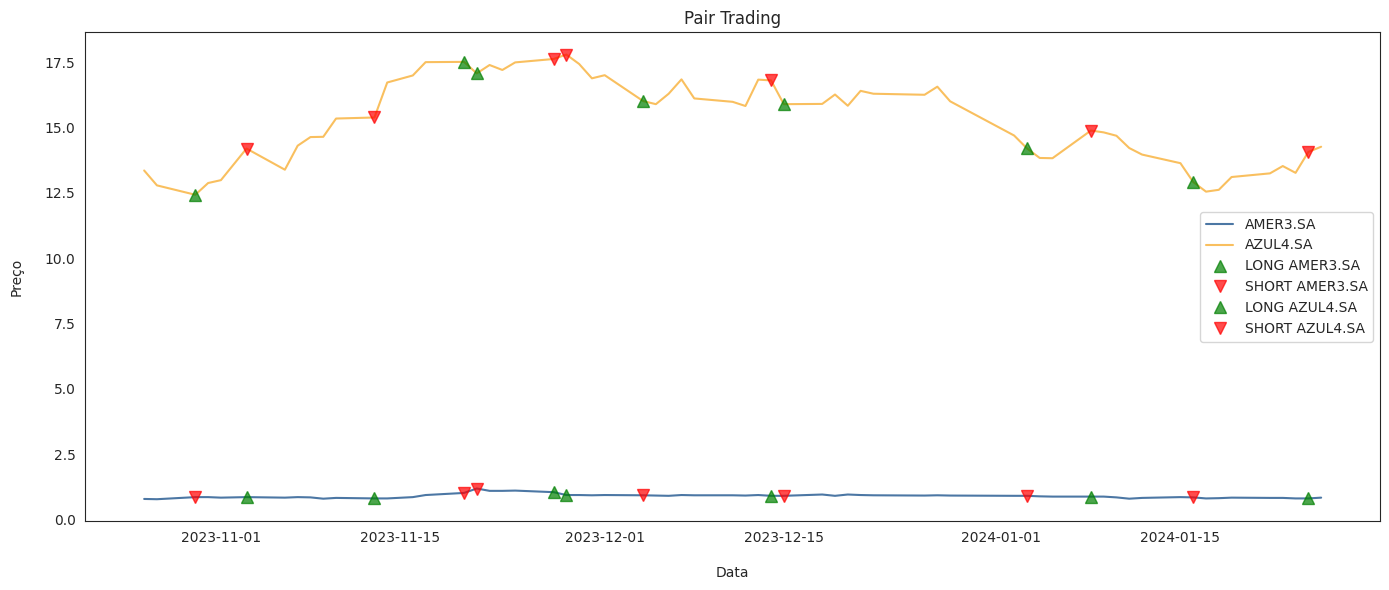

In [74]:
view_trades_spread(('AMER3.SA', 'AZUL4.SA')) #exemplo da função para um par aleatório

In [50]:
def performance_spread(pair): # essa função retorna um gráfico com a performance do portfólio usando o spread como métrica dado um par
  lucro, sinais_spread, portfolio_spread = backtest_spread(pair,test)
  fig = plt.figure(figsize=(14,6),)
  ax = fig.add_subplot(111)
  ax2 = ax.twinx()
  l1, = ax.plot(portfolio_spread['total ativos'], c='#3CB81D')
  l2, = ax2.plot(portfolio_spread['z'], c='black',alpha=0.5)
  b = ax2.fill_between(portfolio_spread.index,portfolio_spread['z limite superior'],portfolio_spread['z limite inferior'],alpha=0.15,color='gray')
  c = ax2.fill_between(portfolio_spread.index,portfolio_spread['z fecha superior'],portfolio_spread['z fecha inferior'],alpha=0.15,color='#003F7D')
  ax.set_ylabel('Valor do Portfólio')
  ax2.set_ylabel('Z-score do spread',rotation=270)
  ax.yaxis.labelpad=15
  ax2.yaxis.labelpad=15
  ax.set_xlabel('Data')
  ax.xaxis.labelpad=15
  plt.title('Desempenho do Par')
  plt.legend([l2,b,l1],['Z-score do spread','Região de trade','Valor Total do Portfólio'],loc='upper left');

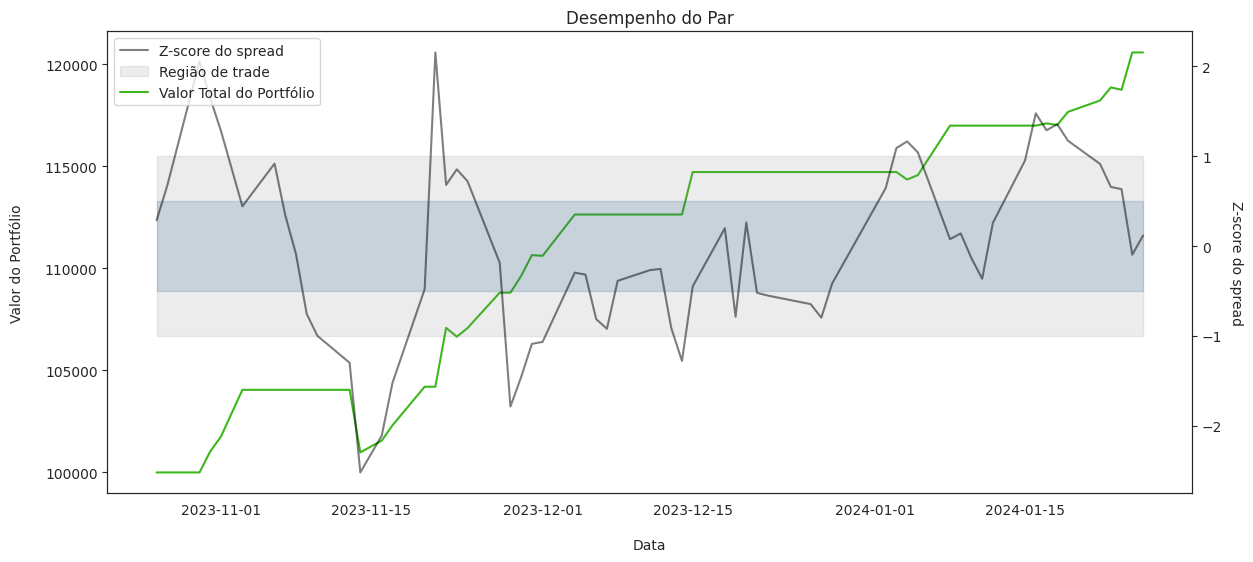

In [73]:
performance_spread(('AMER3.SA', 'AZUL4.SA')) #exemplo da função para um par aleatório

# Estratégia

Vamos criar uma função para rodar a estratégia. Ela recebe a base de dados, a janela de dias de treino+teste e o tamanho do teste. Veja uma imagem que descreve o que essa função faz:


Essa função faz o seguinte:
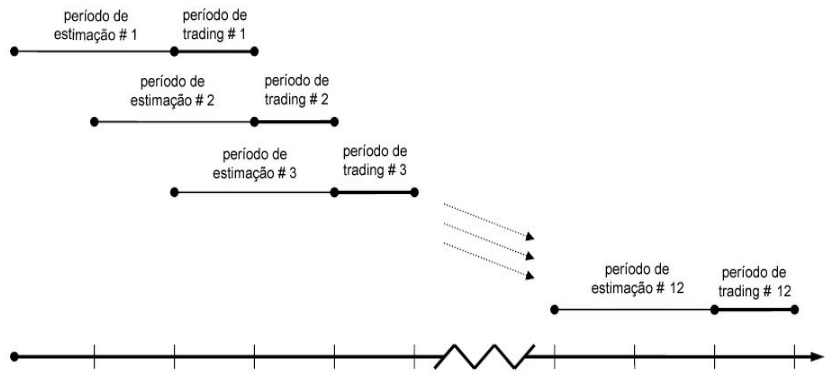

1.   Olha para uma janela da base de dados de cada vez. Se a base de dados possui 2 anos e você escolhe um window_days=252 (1 ano) e um test_size=0.25, isto é, 25% do window_days, teremos um teste de 1 trimestre. Depois de rodar o teste, a janela toda se descoloca em 1 trimestre para operar no próximo trimestre, mas o período de treino também é deslocado. Assim, encontramos novos pares cointegrados e recalculamos os parâmetros para manter o período de teste eficiente.
2.   A cada período de estimação, ela encontra os pares que são cointegrados e roda uma regressão linear para cada um para calcular o beta da regressão que servirá para o cálculo do spread, que é usado como critério para operar.
3.   Rodamos a função de backtest para esses pares em cada período de estimação/treino, armazenamos os resultados e selecionamos os 20 pares que obtiveram as maiores rentabilidades do treino para serem operados no período de teste. Dessa maneira, filtramos e garantimos uma quantidade razoável de pares para operar.
4.   Rodamos a mesma função de backtest no período de treino e armazenamos os resultados.
5.   Deslocamos a janela em 1 teste para operar continuamente.


In [59]:
start='2023-02-01' # definimos o período
end='2024-02-01'
fechamentos_rolling = {}
for i in tickers: # essa iteração baixa a série temporal de close das ações para todos os pares e armazena em um df
  acao = yf.download(i,start,end)
  acao.rename(columns={'Adj Close':i}, inplace=True)
  fechamentos_rolling[i]=acao[i]
fechamentos_rolling_df = pd.DataFrame(fechamentos_rolling)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['BRML3.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%****************

In [60]:
for i in fechamentos_rolling_df.columns: #essa iteração remove todas as ações que na série histórica tenha alguma observação faltando para não gerar problemas
  if fechamentos_rolling_df[i].isnull().any():
    fechamentos_rolling_df.drop(i,axis=1,inplace=True)

In [61]:
len(fechamentos_rolling_df.columns) # número de ativos restantes dos 50 iniciais

46

Recomendação: data = fechamentos_rolling_df ; window_days = 252 ; test_size = 0.25

In [84]:
window_days = 252
test_size = 0.25

returns_rolling = {}
executed_tests = {}
treino = []
teste = []
pares_usados = []
lucros = []
for i in range(int(len(fechamentos_rolling_df)//(window_days*test_size)-((1-test_size)*window_days)/(window_days*test_size))):
  window = fechamentos_rolling_df.iloc[int(i*(window_days*test_size)):int(i*(window_days*test_size)+window_days)] # andando de trimestre em trimestre
  train, test = train_test_split(window, test_size=test_size, shuffle=False)
  treino.append(train.index[0].strftime('%d/%m/%Y')+' até '+train.index[-1].strftime('%d/%m/%Y'))
  teste.append(test.index[0].strftime('%d/%m/%Y')+' até '+test.index[-1].strftime('%d/%m/%Y'))
  pvalues, pairs = find_cointegrated_pairs(train)
  betas = {}
  for j in pairs: # essa iteração armazena todos os betas em um dicionário, onde as chaves são as tuplas com os pares e os respectivos valores são os betas
    betas[j] = train_pair(j)
  results_train = {}
  trades_train = {}
  portfolio_train = {}

  for j in pairs: # essa iteração preenche os dicionários
    results_train[j],trades_train[j],portfolio_train[j]=backtest_spread(j,train) # rodamos o backtest no treino para selecionar os melhores pares para o teste



  best_pairs = list(dict(list({k: v for k, v in sorted(results_train.items(), key=lambda item: item[1])}.items())[-20:]).keys()) # pegamos os 20 pares que mais renderam

  pares_usados.append(best_pairs)

  results_test = {}
  trades_test = {}
  portfolio_test = {}
  for j in best_pairs: # essa iteração preenche os dicionários
    results_test[j],trades_test[j],portfolio_test[j]=backtest_spread(j,test) # rodamos o backtest no test para os pares que apresentarem maiores retornos no treino
  lucros.append(np.array(list(results_test.values())).mean())
  executed_tests[i] = [results_test,trades_test,portfolio_test]

  returns_rolling[i] = sum(results_test.values())/len(results_test)

Esse dicionário abaixo são os retornos médio obtidos para cada período de operação realizado.

In [68]:
returns_rolling

{0: 0.12197520657977963}

Com a lógica abaixo conseguimos acessar as informações de todos os trades realizados. O primeiro index de executed_tests se refere ao período de trade, por exemplo, se for 1 é o primeiro período de trade, se for 2 é o segundo e assim consecutivamente. O segundo index se refere ao tipo de infomação que queremos: 0 são as rentabilidades de cada par dado um período de teste; 1 são os sinais e posições realizadas; 2 são dados dos retornos de cada par. No que tanto 1 quanto 2 precisamos indicar de qual par se trata, por isso o terceiro index é essa lista, o index dessa lista pode ir de 0 a 19, correspondendo a cada par possível.

In [72]:
executed_tests[0][0] # primeiro período de operações, retornos de cada par

{('AMER3.SA', 'CASH3.SA'): 0.06450811944980131,
 ('ABEV3.SA', 'AMER3.SA'): 0.050886192076175354,
 ('AMER3.SA', 'RDOR3.SA'): 0.07155826908171337,
 ('AMER3.SA', 'BBDC4.SA'): 0.11507407668521424,
 ('AMER3.SA', 'GGBR4.SA'): 0.021766841603804495,
 ('AMER3.SA', 'B3SA3.SA'): 0.1049412515026865,
 ('AMER3.SA', 'ASAI3.SA'): 0.07913241973126962,
 ('AMER3.SA', 'PETZ3.SA'): 0.09866353494170704,
 ('AMER3.SA', 'RENT3.SA'): 0.11623607935595705,
 ('BRFS3.SA', 'PETR3.SA'): 0.20394185340450088,
 ('AMER3.SA', 'EMBR3.SA'): 0.18068411504736503,
 ('RRRP3.SA', 'NTCO3.SA'): 0.13239489318852227,
 ('BRFS3.SA', 'PETR4.SA'): 0.19559565963057235,
 ('AMER3.SA', 'LWSA3.SA'): 0.1333326223918746,
 ('AMER3.SA', 'BRKM5.SA'): 0.1784876507365472,
 ('AMER3.SA', 'NTCO3.SA'): 0.07693161425032304,
 ('AMER3.SA', 'MGLU3.SA'): 0.1924200455965982,
 ('AMER3.SA', 'CVCB3.SA'): 0.11617062307076718,
 ('RRRP3.SA', 'AMER3.SA'): 0.1012476620842173,
 ('AMER3.SA', 'AZUL4.SA'): 0.2055306077659753}

In [79]:
executed_tests[2][1][list(executed_tests[2][1].keys())[-2]] # segundo período de operações, sinais e posições para o par de índice 0

0.1012476620842173

In [82]:
executed_tests[2][2][list(executed_tests[2][2].keys())[-2]] # primeiro período de operações, desempenho do par de índice 0

0.1012476620842173

Exportando para um arquivo Excel o relatório da estratégia

In [83]:
resumo = {'Treino':treino,'Teste':teste,'Pares usados':pares_usados,'Rentabilidade Líquida Trimestral':lucros}
resumo_df = pd.DataFrame(resumo)
list_pairs_df = []
for i in resumo_df.index:
  pairs_df = pd.DataFrame(executed_tests[i][0],index=['Rentabilidade Líquida'])
  list_pairs_df.append(pairs_df.transpose())
writer = pd.ExcelWriter('PairsTrading.xlsx', engine='xlsxwriter')

resumo_df.to_excel(writer, sheet_name='Geral')
soma=0
for i in list_pairs_df:
  i.to_excel(writer, sheet_name=str(soma))
  soma+=1

writer.save()

# Referências

## Websites
- https://medium.com/swlh/creating-and-back-testing-a-pairs-trading-strategy-in-python-caa807b70373 \
- https://www.linkedin.com/pulse/statistical-arbitrage-pairs-trading-backtesting-sabir-jana/
- https://www.statisticshowto.com/probability-and-statistics/z-score/

## Artigos
- A Estratégia de Pares no Mercado Acionário Brasileiro o Impacto da Frequência de Dados (2015)
- Análise de Estratégias Pairs Trading através dos Métodos de Cointegração e - Correlação Aplicados ao Mercado Acionário Brasileiro
- Arbitragem Estatística entre Dois Ativos um Estudo da Abordagem de Cointegração no Brasil entre 2003 e 2014 (2017)
- Arbitragem Estatística, Estratégia Long-Short Pairs Trading, Abordagem com Cointegração Aplicada ao Mercado de Ações